In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
## combined

In [3]:
# # Names of the aggregation functions
# agg_funcs = ['min', 'mean', 'max', 'sum']
# # Initialize an empty DataFrame for concatenated features
# concatenated_features = pd.DataFrame()
# for agg_func in agg_funcs:
#     # Load each dataframe
#     df = pd.read_pickle(f'datasets/df_ocp_dpp_{agg_func}.pickle')
#     # Update column names with 'agg_func' prefix for all columns except the last one
#     df.columns = [f"{agg_func}_{col}" if col != 'energy' else col for col in df.columns]
#     # Concatenate features (all columns except the last one)
#     concatenated_features = pd.concat([concatenated_features, df.iloc[:, :-1]], axis=1)
# # Assuming the target column ('energy') is identical in all dataframes, take it from the first dataframe
# target_column = pd.read_pickle('datasets/df_ocp_dpp_min.pickle')['energy']
# # Combine the concatenated features with the target column
# final_df = pd.concat([concatenated_features, target_column], axis=1)
# print(final_df.shape)
# # Save the final dataframe as a pickle file
# final_df.to_pickle('datasets/df_ocp_dpp_combined.pickle')

In [4]:
## performance evaluation

count    329863.000000
mean         -1.404898
std           2.047871
min          -9.982733
25%          -2.824951
50%          -1.591082
75%          -0.209614
max           9.999101
Name: energy, dtype: float64


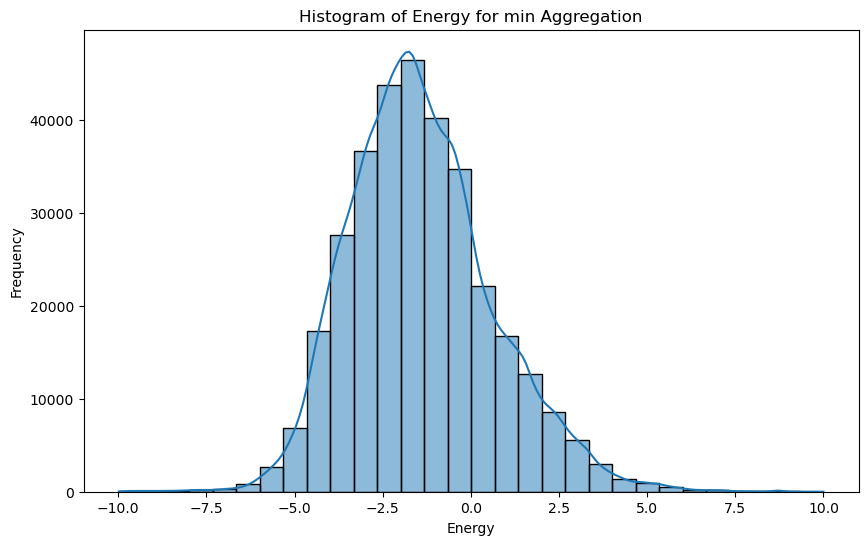

In [5]:
agg_funcs = ['min', 'mean', 'max', 'sum', 'combined']
for agg_func in agg_funcs[:1]:
    # Load dataframe
    df = pd.read_pickle(f'datasets/df_ocp_dpp_{agg_func}.pickle')
    print(df['energy'].describe())
    
    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(df['energy'], bins=30, kde=True)
    plt.title(f'Histogram of Energy for {agg_func} Aggregation')
    plt.xlabel('Energy')
    plt.ylabel('Frequency')
    plt.show()

(329863, 257)
-9.982733039999971 9.999100859999942 (329863, 257)


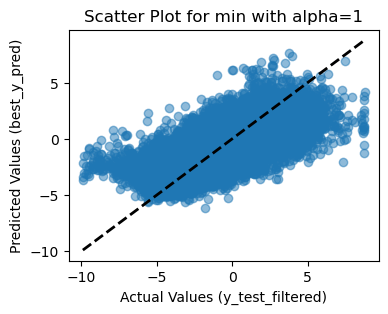

(329863, 257)
-9.982733039999971 9.999100859999942 (329863, 257)


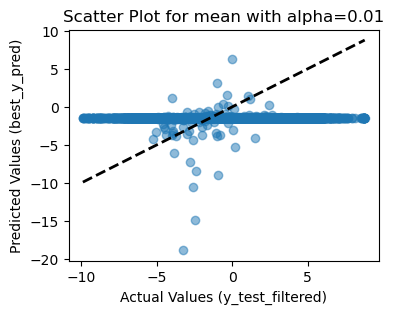

(329863, 257)
-9.982733039999971 9.999100859999942 (329863, 257)


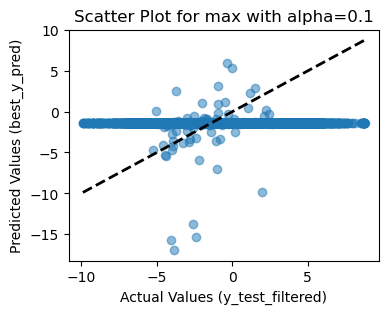

(329863, 257)
-9.982733039999971 9.999100859999942 (329863, 257)


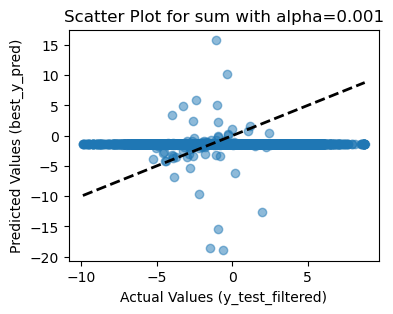

(329863, 1025)
-9.982733039999971 9.999100859999942 (329863, 1025)


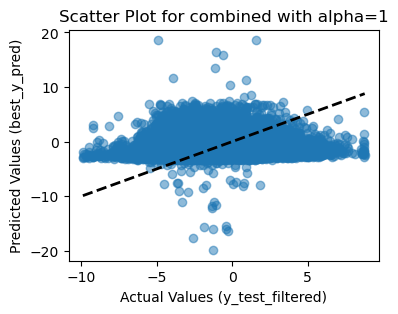

In [6]:
hyperparams = [0.001, 0.01, 0.1, 1]
agg_funcs = ['min', 'mean', 'max', 'sum', 'combined']
best_scores = {}
best_alphas = {}

for agg_func in agg_funcs:
    # Load dataframe
    df = pd.read_pickle(f'datasets/df_ocp_dpp_{agg_func}.pickle')
    ##########################################################################
    print(df.shape)
    # Calculate the mean and standard deviation
    mean_energy = df['energy'].mean()
    std_energy = df['energy'].std()
    # Define the range for filtering: mean ± 3std
    lower_bound = df['energy'].min() ## mean_energy - 3 * std_energy
    upper_bound = df['energy'].max() ## mean_energy + 3 * std_energy
    # Filter the DataFrame
    df = df[(df['energy'] >= lower_bound) & (df['energy'] <= upper_bound)]
    print(lower_bound, upper_bound, df.shape)
    ##########################################################################
    
    # Splitting into features and target
    X = df.iloc[:, :-1]  # Assuming last column is 'energy'
    y = df['energy']  
    # Splitting into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Reset the index of y_test here, outside the loop
    y_test_reset = y_test.reset_index(drop=True)
    
    # Variables to store the best score and alpha for the current dataframe
    best_score = float('inf')
    best_alpha = None
    best_y_pred = None
    for alpha in hyperparams:
        # Initialize and train model
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)
        # Make predictions and evaluate
        y_pred = model.predict(X_test)
        ## todo:         
        valid_pred_mask = (y_pred >= -20) & (y_pred <= 20)
        y_pred_filtered = y_pred[valid_pred_mask]
        y_test_filtered = y_test_reset[valid_pred_mask]
        # y_pred_filtered = y_pred
        # y_test_filtered = y_test_reset
        
        score = mean_absolute_error(y_test_filtered, y_pred_filtered)
        # Update the best score and alpha if the current model is better
        if score < best_score:
            best_score = score
            best_alpha = alpha
            best_y_pred = y_pred_filtered

    # Store the best score and alpha for the current dataframe
    best_scores[agg_func] = best_score
    best_alphas[agg_func] = best_alpha
    # Plot y_test_filtered vs best_y_pred
    plt.figure(figsize=(4, 3))      
    plt.scatter(y_test_filtered, best_y_pred, alpha=0.5)
    plt.xlabel('Actual Values (y_test_filtered)')
    plt.ylabel('Predicted Values (best_y_pred)')
    plt.title(f'Scatter Plot for {agg_func} with alpha={best_alpha}')
    plt.plot([y_test_filtered.min(), y_test_filtered.max()], [y_test_filtered.min(), y_test_filtered.max()], 'k--', lw=2)
    plt.show()


In [7]:
# Print the best alpha for each dataframe
for agg_func in agg_funcs:
    print(f"Best alpha for {agg_func}: {best_alphas[agg_func]} with score: {best_scores[agg_func]}")
print(np.mean(np.abs(y_test)))

Best alpha for min: 1 with score: 1.0335410696311031
Best alpha for mean: 0.01 with score: 1.603557324583589
Best alpha for max: 0.1 with score: 1.6038472633466925
Best alpha for sum: 0.001 with score: 1.6044710914682738
Best alpha for combined: 1 with score: 1.7085232914070758
2.0721366773765038
